# TMA4320 Technical Physics Project
### Oliver Ruden, Åsmund Mjøs & Astrid Mysterud

In [77]:
# we start by importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from time import time
from hjelpefunksjoner import *
from scipy.interpolate import RectBivariateSpline
import timeit
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# %load_ext line_profiler

In this project we are to calculate particle transport, using wind and ocean current forecasts. Similar calculations as in this project are used to track e.g. oil spills and how plastic moves in the ocean. We will start by looking at a test case where the velocity field of the particles is a given function. Later in the project, we are to use wind and ocean current forecasts to calculate the particle movement. Here, we will be assuming that the particles position is determined by the ODE
\begin{align*}
    \dot{\mathbf x}=\mathbf v_c(\mathbf x, t)+f_w\mathbf v_w(\mathbf x, t)
\end{align*}
where $\mathbf v_c$ is the velocity of the ocean current, $\mathbf v_w$ is the velocity of the wind, and $f_w$ is the \emph{windage factor}. The windage factor is decided by how much the wind affects the particle transport. Towards the end of the project, different windage factors will be tested to analyze its effect on the particle transport.

We start by analyzing a simple test case, where the position of the particles is determined by the ODE
\begin{align*}
    \dot{\mathbf{x}}&=\mathbf{f}(\mathbf{x},t)\\
    &=[v_x(\mathbf{x},t), v_y(\mathbf{x},t)]
\end{align*}
where the velocity components and the parameters are as described in equation $(4)$ in the project description. We will be looking at the region $x\in[0,2]$ and $y\in[0,1]$, and the time interval $t\in[0,50]$. The following code block initializes the parameters $A$, $\epsilon$ and $\omega$, and defines the functions as in equation $(4)$.

In [78]:
"""
Initializing parameters
"""
A = 0.1
epsilon = 0.25
omega = 1

"""
Defining the velocity field
"""

a = lambda t: epsilon * np.sin(omega * t)
b = lambda t: 1 - 2 * epsilon * np.sin(omega * t)

f = lambda x, t : a(t) * x ** 2 + b(t) * x
dfdx = lambda x, t : 2 * a(t) * x + b(t)

v_x = lambda x, y, t: -np.pi * A * np.sin(np.pi * f(x, t)) * np.cos(np.pi * y)
v_y = lambda x, y, t: np.pi * A * np.cos(np.pi * f(x, t)) * np.sin(np.pi * y) * dfdx(x, t)

func = lambda coord, t: np.array([v_x(coord[0],coord[1], t), v_y(coord[0], coord[1], t)])

To solve this ODE, we will be using Heuns method as described in equation $(2)$ in the project description. The following code block implements Heuns method.

In [79]:
def heun(func, start_coords, t_start, t_end, h):

    """
    Heuns method.
    Input:
    func: \dot{x}=func
    start_coords: array with initial positions of particles
    t_start: start time
    t_end: end time
    h: step length
    """

    t_array = np.arange(t_start, t_end, h)

    """
    Creating array for the coordinates of the particles.
    Adjusting for the case where there's only one particle.
    """
    if np.shape(start_coords) == (2, ):
        coords = np.zeros((np.shape(t_array) + np.shape(start_coords)) + (1, ))
        start_coords = start_coords.reshape((2, 1))
    else:
        coords = np.zeros((np.shape(t_array) + np.shape(start_coords)))

    coords[0] = start_coords

    for i in range(len(t_array) - 1):
        k_1 = func(coords[i], t_array[i])
        k_2 = func(coords[i] + h * k_1, t_array[i + 1])
        coords[i + 1] = coords[i] + h / 2 * (k_1 + k_2)
    
    return [t_array, coords]

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\aasmu\AppData\Local\Temp\ipykernel_38308\1967805314.py:3: SyntaxWarning: invalid escape sequence '\d'
  """


Now that we have defined the velocity field and Heuns method, we calculate the trajectory of a particle with initial position in the coordinates $[1.05, 0.5]$. The following code block plots this trajectory for different step lengths $h\in\{0.01, 0.05, 0.1, 0.2\}$. First, we look at the time interval $t\in[0,50]$.

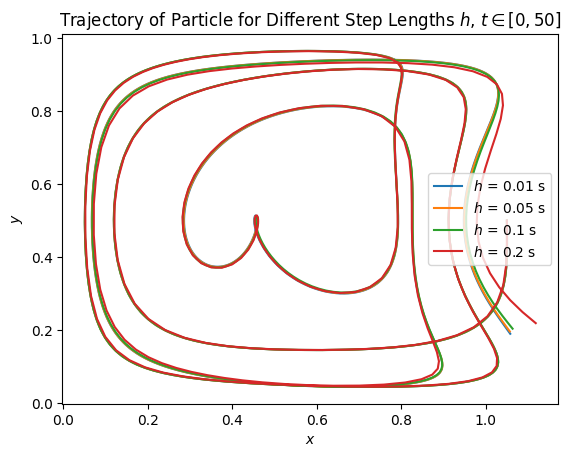

In [80]:
coord_0 = np.array([1.05, 0.5])
t_start = 0
t_end = 50

for h in [0.01, 0.05, 0.1, 0.2]:
    [t_array, coords] = heun(func, coord_0, t_start, t_end, h)
    plt.plot(coords[:,0,:], coords[:,1,:], label = rf'$h$ = {h} s')

plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Trajectory of Particle for Different Step Lengths $h$, $t\in[0,50]$')
plt.show()

The above plot shows that $h=0.05\text s$ seems like a reasonable step length. $h=0.1\text s$ also looks fairly accurate, but would possibly not be appropriate for a greater integration time. The following code block tests the step lengths $h\in\{0.0005, 0.001, 0.005, 0.01, 0.05, 0.1\}$ for the integration time $t\in[0, 100]$.

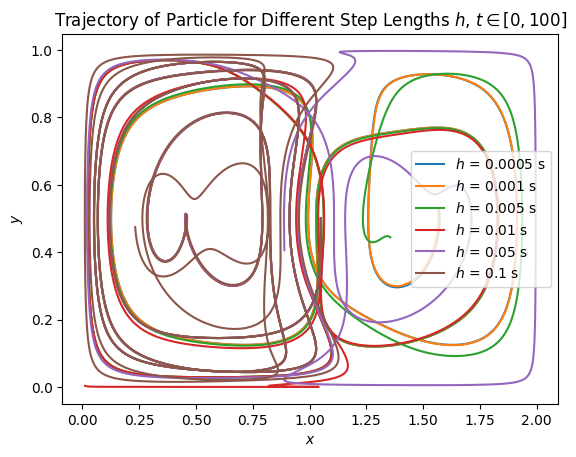

In [81]:
t_end = 100
results = []
hArray = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
for h in hArray:
    individualResult = heun(func, coord_0, t_start, t_end, h)
    results.append(individualResult)
    [t_array, coords] = individualResult
    plt.plot(coords[:,0,:], coords[:,1,:], label = rf'$h$ = {h} s')

plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Trajectory of Particle for Different Step Lengths $h$, $t\in[0,100]$')
plt.show()

This looks pretty chaotic, let's look at the carthesian distance of the trajectories relative to the trajectory with the smallest step length, to measure accuracy

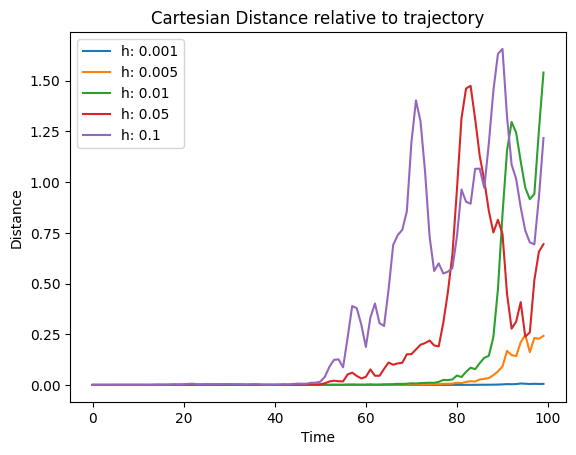

In [82]:

i=1
for h in hArray[1:]:
    carthesianDistance = []

    timeStamps = 0
    relativetimeStamps = 0
    timeList = []
    [t_array, coords] = results[i]

    while (timeStamps < len(t_array)):

        timeList.append(t_array[timeStamps])
        x = coords[timeStamps][0][0]
        y = coords[timeStamps][1][0]
        x_relative = results[0][1][relativetimeStamps][0][0]
        y_relative = results[0][1][relativetimeStamps][1][0]
        carthesianDistance.append(np.sqrt((x-x_relative)**2 + (y-y_relative)**2))
        timeStamps += int(1/h)
        relativetimeStamps += int(1/hArray[0])
    
    # plt.plot(time, carthesianDistance, label = f'h: {h}')
    plt.plot(timeList, carthesianDistance, label = f'h: {h}')
    i+=1

plt.title("Cartesian Distance relative to trajectory")
plt.xlabel("Time")
plt.ylabel("Distance")
plt.legend()
plt.show()

As we can see from the plot, a step length of $h = 0.05$ ends up following a completely different path than the one with step length $h = 0.0005$. We can therefore conclude that this step length of $h = 0.05$ is no longer adequate. Based on this plot, we'd say that a step length of $h = 0.001$ is reasonably short.

Now, we are to test Heuns method on multiple particles. This is done by calculating the trajectory of $N_p$ initial conditions, where $N_p$ is the number of particles. We continue with the step length $h=noe$ from last task. 

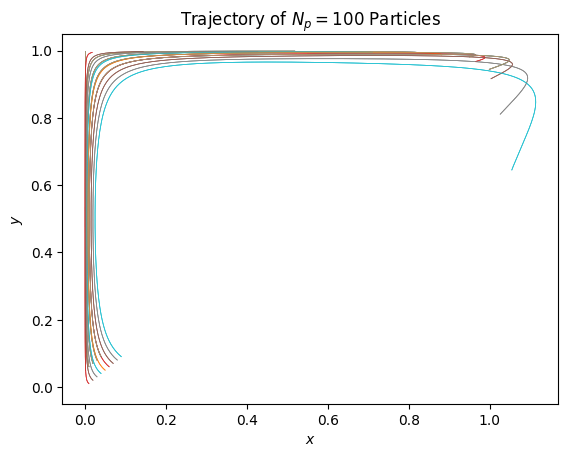

In [83]:
"""
Calculating trajectory for multiple particles
!!! LEGGE TIL SCATTER AV START OG SLUTT
"""

N_p = 100
N_ps = int(np.sqrt(N_p))

x_max = 0.1
y_max = 0.1
t_start = 0
t_end = 10
h = 0.05

if N_p != N_ps ** 2:
    print("Invalid dimensions")

else:
    start_coords = np.array([(i / N_ps * x_max, j / N_ps * y_max) for i in range(N_ps) for j in range(N_ps)]).reshape(2, N_p)

t_array, coords = heun(func, start_coords, t_start, t_end, h)

plt.plot(coords[:,0,:], coords[:,1,:], alpha = 0.5, lw = 0.5)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(rf'Trajectory of $N_p=${N_p} Particles')
plt.show()

In order to make the code efficient, we have implemented the $\texttt{heun}$ function to calculate trajectories for several initial conditions simultaneously. As asked in task **1c**, we now test how the number of particles affect the run time of the code. Next code block plots the run time for different number of particles $N_p\in\{10, 10^2, 10^3, 10^4, 10^5\}$, with step length $h=0.1$ in the time interval $t\in[0, 50]$.

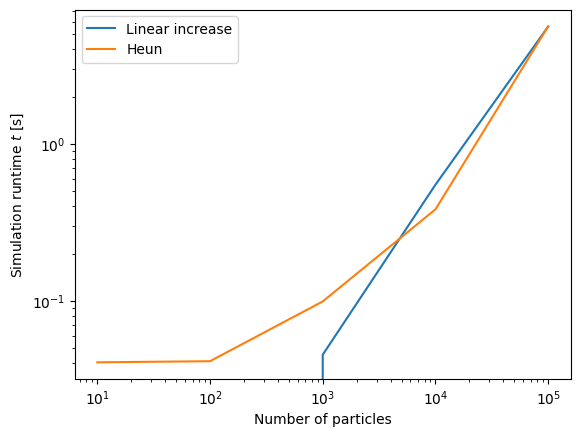

In [84]:
"""
Testing how number of particles N_p affect the run time
!!! Teste flere N_p?
"""

N_p = np.array([10, 10**2, 10**3, 10**4, 10**5])
times = []

for n_p in N_p:
    start_time = time()
    heun(func, np.array([coord_0] * n_p).transpose(), 0, 50, 0.1)
    end_time = time()
    times.append(end_time - start_time)

def linear_func(x):
    [a, b] = np.polyfit(N_p, times, 1)
    return a * x + b

plt.loglog(N_p, linear_func(N_p), label = "Linear increase")
plt.loglog(N_p, times, label = "Heun")
plt.xlabel("Number of particles")
plt.ylabel(r'Simulation runtime $t$ [s]')
plt.legend()
plt.show()

*Drøfting av ting*

That concludes the first part of the project. Now we will use wind and ocean current forecasts, instead of a given function for the velocity field. The position of the particle is determined by the ODE
\begin{align*}
    \dot{\mathbf x}=\mathbf v_c(\mathbf x, t)+f_w\mathbf v_w(\mathbf x, t)
\end{align*}
as described in the project description. We will start by using a windage factor $f_w = 0.03$. As mentioned in task **2a**, we use initial coordinates from an area west of Trondheim.

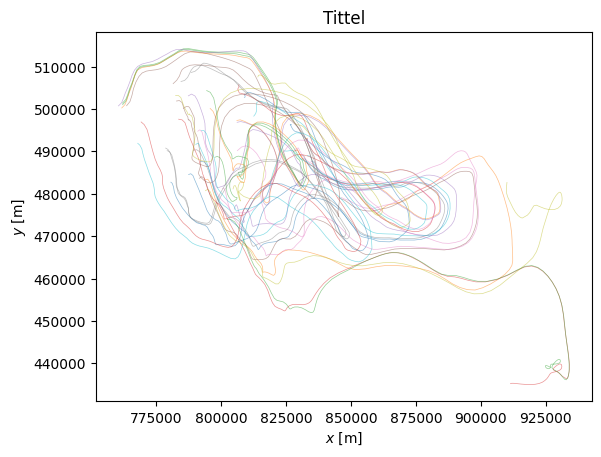

In [85]:
t_start = 0
t_end = 3600 * 24 * 5 # seconds, 5 days
h = 3600 # seconds
N_p = 30 # particles 

"""
Creating random initial coordinates
"""
start_coords = np.random.normal(490000, 10000, (2, N_p))
start_coords[0, :] += 300000

"""
Collecting wind and ocean current forecast data
"""
forecast_data = xr.open_dataset('./NorKyst-800m.nc')
func = Interpolator(dataset = forecast_data)

t_array, coords = heun(func, start_coords, t_start, t_end, h)

plt.plot(coords[:,0,:], coords[:,1,:], alpha = 0.5, lw = 0.5)
plt.xlabel(r'$x$ [m]')
plt.ylabel(r'$y$ [m]')
plt.title(rf'Tittel')
plt.show()

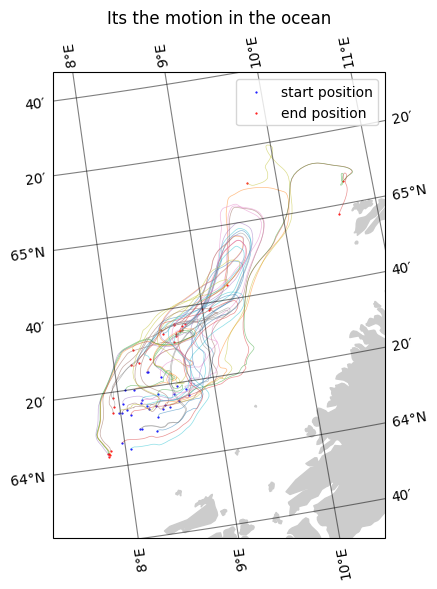

In [86]:
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color = '#cccccc'))

# Create projection object for converting particle positions
npstere = ccrs.Stereographic(
    central_latitude = 90,
    central_longitude = func.dataset.projection_stere.straight_vertical_longitude_from_pole,
    false_easting = func.dataset.projection_stere.false_easting,
    false_northing = func.dataset.projection_stere.false_northing,
    true_scale_latitude = func.dataset.projection_stere.standard_parallel,
)

# scatter plot positions, note the extra transform keyword
# ax.scatter(vals[:,0,:], vals[:,1,:], s=1, transform=npstere, lw=.5, alpha=.5)
ax.plot(coords[:,0,:], coords[:,1,:], transform=npstere, lw=.5, alpha=.5)   
ax.scatter(coords[0,0,:], coords[0,1,:], transform=npstere, color = "blue", label = "start position", s = 0.3)
ax.scatter(coords[-1,0,:], coords[-1,1,:], transform=npstere, color = "red", label = "end position", s = 0.3)

# Make outline a bit larger
# ax.set_extent((7, 11, 63.5, 66))
ax.set_extent([np.min(coords[:,0,:])*0.98, np.max(coords[:,0,:])*1.02, np.min(coords[:,1,:])*0.98, np.max(coords[:,1,:])*1.02], crs=npstere)
# Add gridlines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k')

ax.set(title = "Its the motion in the ocean")
ax.legend()
plt.tight_layout()
plt.show()

# 2b

In [87]:
# code for 2b

# 3a

Skriv om at ting som starter ish samme sted vil ligge oppå hverandre på grunn av skalaer og oppføre seg likt. Og at ting randomly stopper midt på havet

In [88]:
def stranded_heun(func, start_val, t_start, t_stop, h):
    t_array = np.arange(t_start, t_stop, h)

    counter = np.zeros_like(t_array)

    if np.shape(start_val) == (2,):
        val_array = np.zeros((np.shape(t_array)+np.shape(start_val))+(1,))
        start_val = start_val.reshape((2,1))
    else:
        val_array = np.zeros((np.shape(t_array)+np.shape(start_val)))

    
    val_array[0] = start_val
    for i in range(len(t_array)-1):
        k_1 = func(val_array[i],t_array[i])
        k_2 = func(val_array[i]+h*k_1, t_array[i+1])
        val_array[i+1] += val_array[i]
        val_array[i+1,:,counter[i]:]+=h/2*(k_1[:,counter[i]:]+k_2[:,counter[i]:])

        stranded_index = func.on_land(val_array[i+1,:,counter[i]:])
        test = func.on_land(val_array[i+1,:,:counter[i]])


        counter[i+1]=counter[i]
        for idx in range(len(stranded_index)):
            if stranded_index[idx]:
                index = idx + counter[i]
                val_array[:,:,index], val_array[:,:,counter[i+1]] = np.copy(val_array[:,:,counter[i+1]]), np.copy(val_array[:,:,index])
                counter[i+1]+=1
    atest = func.on_land(val_array[-1])
    return [t_array, val_array, counter]

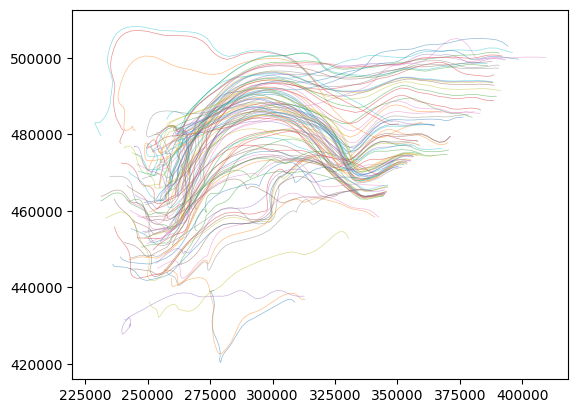

In [89]:
N_p = 100
t_0 = 0
t_end = 3 * 24 * 3600
h = 3600

coords = np.random.normal(250000, 10000, (2,N_p))
coords[1,:] += 210000

d  = xr.open_dataset('./NorKyst-800m.nc')
f  = Interpolator(dataset = d)
t, vals, counter = stranded_heun(f, coords, t_0, t_end, h)

plt.plot(vals[:,0,:], vals[:,1,:], alpha=0.5, lw=0.5)

plt.show()
###############################################################################################################333

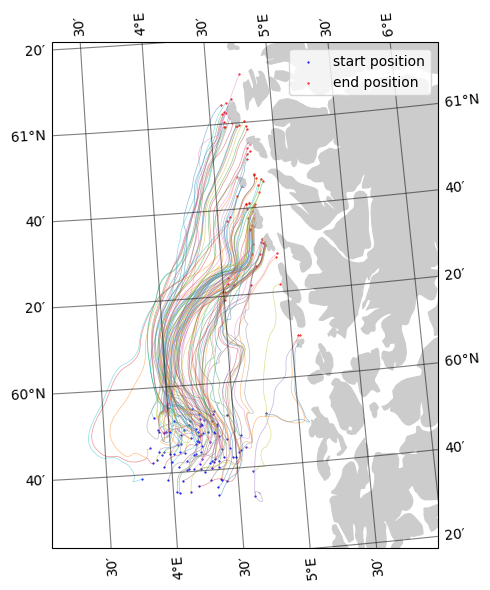

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  5 12 18 22 31 35 37 50]


In [90]:
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color = '#cccccc'))

# Create projection object for converting particle positions
npstere = ccrs.Stereographic(
    central_latitude = 90,
    central_longitude = f.dataset.projection_stere.straight_vertical_longitude_from_pole,
    false_easting = f.dataset.projection_stere.false_easting,
    false_northing = f.dataset.projection_stere.false_northing,
    true_scale_latitude = f.dataset.projection_stere.standard_parallel,
)

# scatter plot positions, note the extra transform keyword
# ax.scatter(vals[:,0,:], vals[:,1,:], s=1, transform=npstere, lw=.5, alpha=.5)
ax.plot(vals[:,0,:], vals[:,1,:], transform=npstere, lw=.5, alpha=.5)   
ax.scatter(vals[0,0,:], vals[0,1,:], transform=npstere, color = "blue", label = "start position", s = 0.3)
ax.scatter(vals[-1,0,:], vals[-1,1,:], transform=npstere, color = "red", label = "end position", s = 0.3)

# Make outline a bit larger
# ax.set_extent((7, 11, 63.5, 66))
ax.set_extent([np.min(vals[:,0,:])*0.98, np.max(vals[:,0,:])*1.02, np.min(vals[:,1,:])*0.98, np.max(vals[:,1,:])*1.02], crs=npstere)
# Add gridlines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k')

ax.legend()
plt.tight_layout()
plt.show()

print(counter)

# 3b

Observerer at plast flyr over land for høye vindfaktorer, gir mening fordi h=3600s og høy vind gir lang steglengde

Data for fw = 0


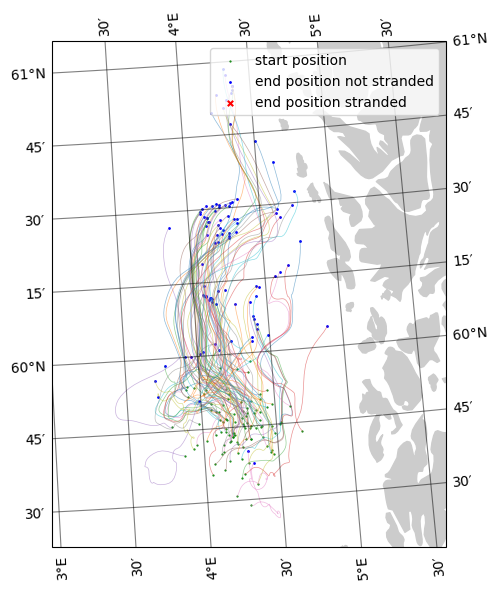

fw: 0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Data for fw = 0.01


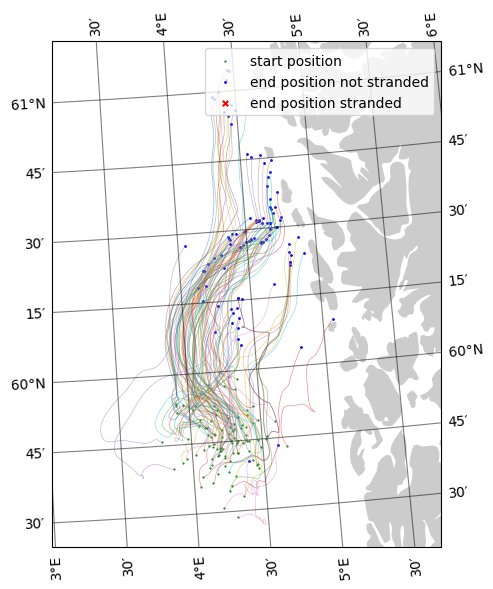

fw: 0.01
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Data for fw = 0.02


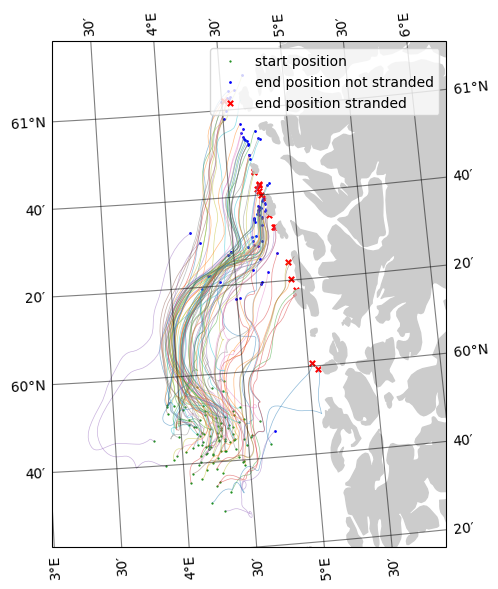

fw: 0.02
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  3  4  6  9 14 17 19]
Data for fw = 0.03


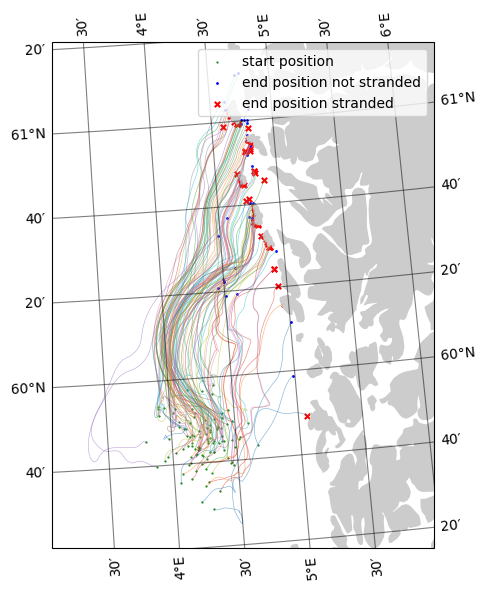

fw: 0.03
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  3  6  9 11 14 28 31 39 43 47 58]
Data for fw = 0.05


C:\Users\aasmu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\cartopy\mpl\geoaxes.py:508: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().get_tightbbox(renderer, *args, **kwargs)


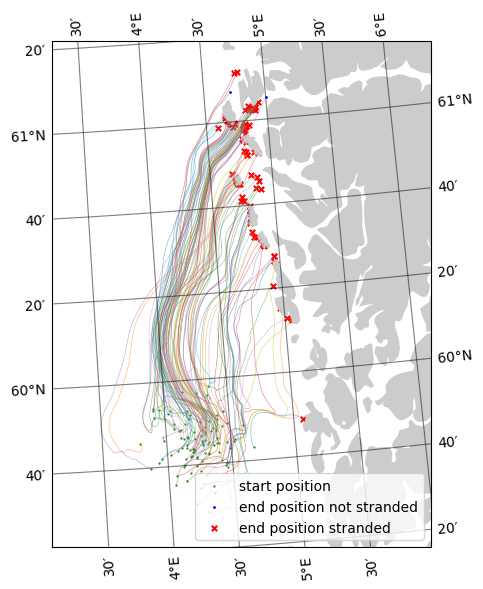

fw: 0.05
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2
  2  2  2  2  4  5  5  6 10 13 16 23 27 35 42 53 71 77 84 91 94 94 95 96]
Data for fw = 0.1


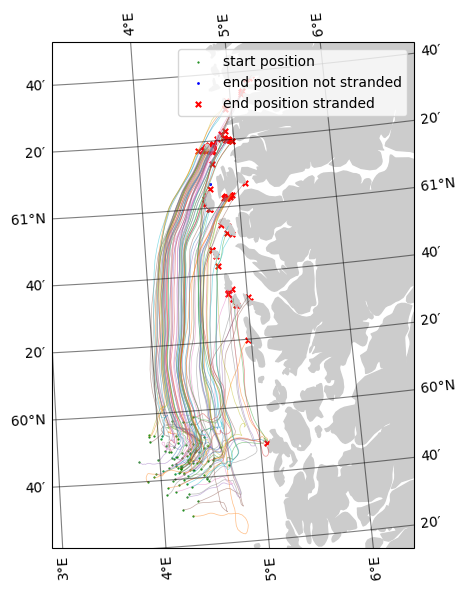

fw: 0.1
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  4  6  9  9
 13 14 18 21 26 31 46 61 68 78 82 86 87 91 92 93 96 97 98 98 98 98 98 98]
Data for fw = 0.15


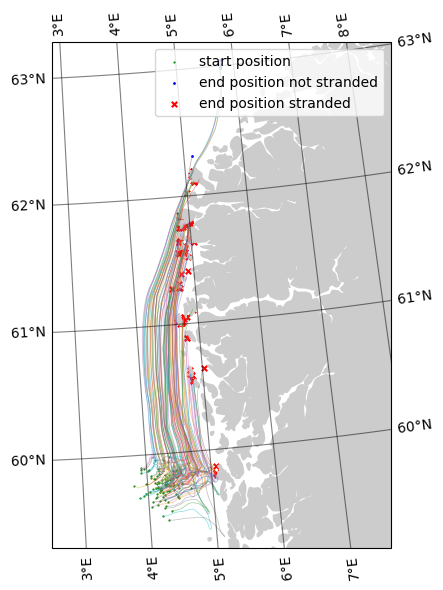

fw: 0.15
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  3  3  3  3  3
  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  7 11 12 14 18 24
 29 30 30 39 44 48 55 65 78 85 87 91 91 93 93 93 94 94 94 94 94 94 94 94]
Data for fw = 1


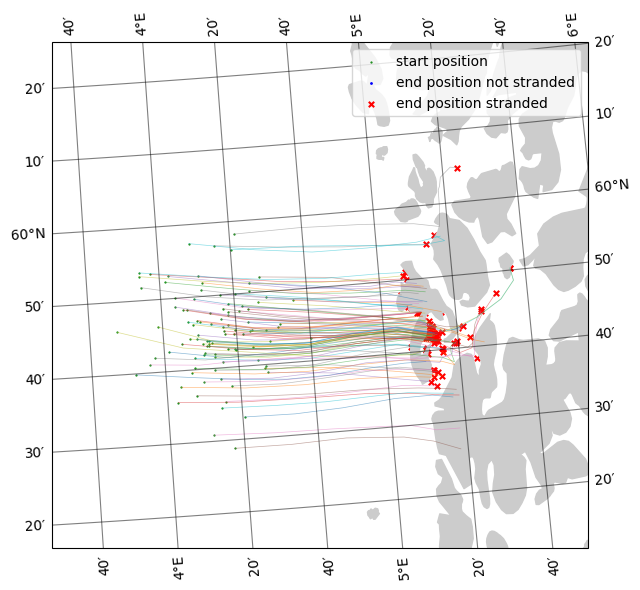

fw: 1
[  0   0   0  12  32  72  86  91  92  97  98  98  98 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100]


In [91]:
# different windage factors

N_p = 100
t_0 = 0
t_end = 3 * 24 * 3600
h = 3600

coords = np.random.normal(250000, 10000, (2,N_p))
coords[1,:] += 210000

for f_w in [0, 0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 1]:

    d  = xr.open_dataset('./NorKyst-800m.nc')
    f  = Interpolator(dataset = d, fw=f_w)
    print(f"Data for fw = {f_w}")
    t, vals, counter = stranded_heun(f, coords, t_0, t_end, h)

    fig = plt.figure(figsize=(9,6))

    ax = plt.axes(projection=ccrs.NorthPolarStereo())

    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color = '#cccccc'))

    # scatter plot positions, note the extra transform keyword
    # ax.scatter(vals[:,0,:], vals[:,1,:], s=1, transform=npstere, lw=.5, alpha=.5)
    ax.plot(vals[:,0,:], vals[:,1,:], transform=npstere, lw=.5, alpha=.5)   
    ax.scatter(vals[0,0,:], vals[0,1,:], transform=npstere, color = "green", label = "start position", s = 0.3)
    ax.scatter(vals[-1,0,counter[-1]:], vals[-1,1,counter[-1]:], transform=npstere, color = "blue", label = "end position not stranded", marker = "o", s = 1)
    ax.scatter(vals[-1,0,:counter[-1]], vals[-1,1,:counter[-1]], transform=npstere, color = "red", label = "end position stranded", marker = "x", s = 15)

    # Make outline a bit larger
    # ax.set_extent((7, 11, 63.5, 66))
    ax.set_extent([np.min(vals[:,0,:])*0.98, np.max(vals[:,0,:])*1.02, np.min(vals[:,1,:])*0.98, np.max(vals[:,1,:])*1.02], crs=npstere)
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k')

    ax.legend()
    plt.tight_layout()
    plt.show()

    print("fw:", f_w)
    print(counter)


###############################################################################################################333

# conclusion